# Introduction

Medical Engineering is a field comprehending the fusion of health science, computer science, signal processing, and robotics. Currently, I am inclined to research in health engineering and I am starting my first Python experimentation project on __pneumonia classification__ using CNN.

## Common issues that are present in medical image classification problems

1. Data Imbalance
    - Problem: Relatively lower number of +ve classes.
    - Solution:
        1. Weight loss functions
        2. Data Resampling -> Over/Under-sampling 
2. Multi-task problem
    - Problem: Use a single model to classify multiple diseases.
    - Solution: Use the multi-task loss function. 
3. Dataset size
    - Problem: Usually, medical image datasets are ~10k to ~100k images with labels. Not sufficient for optimizing CNNs.
    - Solution:
        1. Transfer Learning -> Fine-tuning from the pre-trained model by freezing shallow layers and fine-tuning deeper layers.
        2. Data Augmentation -> Careful that augmentation doesn't change the label for the samples.

# About the notebook

In this notebook, I will be experimenting on _classification of X-ray (normal/pneumonia) using simple basic CNN with weighted loss function_ to set the baseline. The organization of the notebook is as follows:

## Table of contents
1. [About the dataset](#about-the-dataset)
2. [Data Fetch, Preprocess, and Visualization](#data-preprocess)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)

# About the dataset <a id="about-the-dataset"></a>

## Context
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image categor). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a  expert.
### Acknowledgements
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5154-5rt.



# Coding Section

## Imports

Let's gather the basic required libraries utilized throughout the experimentation.

In [5]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch

torch.manual_seed(0)
%matplotlib inline

In [6]:
print(torch.__version__)

2.1.0+cu121


## Define Constants

Constants will be used multiple times, as global variables, within this notebook. Let's define some. 

In [7]:
# Select the device to use for training and inference.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [8]:
# directory constants
DATA_DIR = Path("../data/chest_xray/")
MODEL_DIR = Path("../models/")
PLOT_DIR = Path("../plots/")

In [9]:
# Proprocessing and Model constants
IMAGE_SIZE = [224, 224] # resize dimensions
BATCH_SIZE = 64 # mini-batch size
EPOCHS = 10 # number of epochs to train
LEARNING_RATE = 0.001 # learning rate of the model

## Data Fetch, Preprocess and Visualization <a id="data-preprocess"></a>

Until we fetch the data, moving with other steps of the pipeline is nearly impossible. |

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

Let's begin by creating train/val/test DataLoader objects, I did the following:
1. Define transformation to be applied to the dataset.
   - Nothing extra will be done for the first iterationm, just image resizing and PIL-image to torch.Tensor conversion.
2. Define Pytorch's easy-to-use `torchvision.datasets.ImageFolder` api to load dataset from folder. The object auto extracts classes from the subfolders as a plus.


### Data Augmentation (Transforms)

In [11]:
# Define transformations for viewing and computing mean/std
view_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize images to a common size
    transforms.ToTensor(),
])

### Loading the dataset

Load the dataset using pytorch's api.

In [12]:
# dataset for viewing
training_dataset_view = ImageFolder(
    root = DATA_DIR/ "train",
    transform = view_transform
)

In [13]:
train_view_loader = DataLoader(training_dataset_view, batch_size=25, num_workers=0, shuffle=True, drop_last=False)

Find mean and std for normalization

In [10]:
# mean = 0.0

# for images, _ in train_view_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
# mean = mean/len(train_view_loader.dataset)

# pixel_count = 0
# var = 0.0
# for images, _ in train_view_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     var += ((images - mean.unsqueeze(1))**2).sum([0,2])
#     pixel_count += images.nelement()
    
# std = torch.sqrt(var / pixel_count)

In [11]:
# mean

In [12]:
# std

__Note__: The 3 channels have the same mean and standard deviation values because the X-ray image is in black and white.

Next, let's define the actual transformation to utilize for training, testing, validation set - In addition to view transformation, I have included standardization to center the dataset to 0 mean and 1 std dev.

In [14]:
actual_transforms =  transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize images to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4823, 0.4823, 0.4823], std=[0.1363, 0.1363, 0.1363]) # use mean and std here.
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # use mean and std here.
])

In [15]:
training_dataset = ImageFolder(
    root = DATA_DIR / "train",
    transform = actual_transforms,
)

In [16]:
val_dataset = ImageFolder(
    root = DATA_DIR / "val",
    transform = actual_transforms,
)

In [17]:
test_dataset = ImageFolder(
    root = DATA_DIR / "test",
    transform = actual_transforms,
)

### Check if dataset if properly loaded

Now, let's visualize the dataset samples based on category. I am defining a simple helper function using matplotlib to plot the images in a 5x5 grid

In [18]:
def show_batch(image_batch, label_batch, image_classes):
    """display batch of image samples in a 5x5 grid."""
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(image_classes[label_batch[n]])
        plt.axis("off")

Let's fetch a batch of images, labels, and category names from ImageFolder object.

pytorch provides `DataLoader` api to fetch dataset in batches with additional tweakable parameters. Let's use it to fetch 25 images randomly from the training set.

In [19]:
image_batch, label_batch, image_classes = *next(iter(train_view_loader)), training_dataset.classes

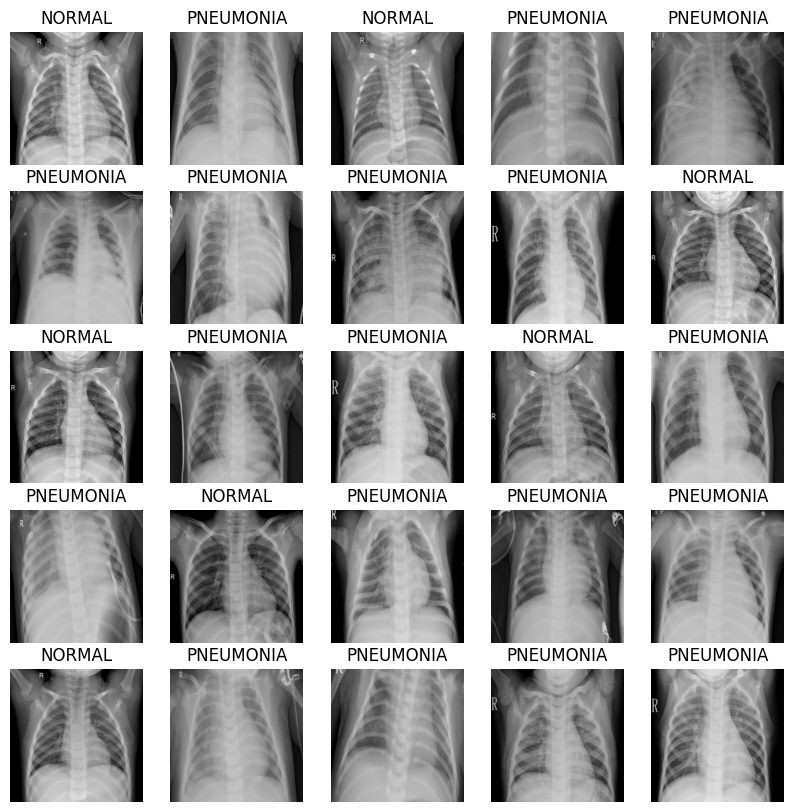

In [20]:
show_batch(image_batch.permute(0, 2, 3, 1), label_batch.numpy(), image_classes)

I am no expert in reading X-ray images, nevertheless, the dataset loaded properly. Let's move on to further EDA.

### Check for data imbalance

As discussed in the introduction, in medical field, data imbalance is a norm. So, let's check for data imbalance in the training set.

In [21]:
# Get the label counts
training_label_count = (pd.Series(training_dataset.targets).value_counts()).sort_index()
validation_label_count = (pd.Series(val_dataset.targets).value_counts()).sort_index()
test_label_count = (pd.Series(test_dataset.targets).value_counts()).sort_index()

Defining another helper function to visualize the label counts.

In [22]:
def plot_label_counts(dataset_count, dataset_type):
    """displays a bar plot showing count of data sample per category"""
    plt.bar(dataset_count.index, dataset_count.values, color=["blue", "orange"])
    plt.xticks(range(len(dataset_count.index)), ['Normal(0)', 'Pneumonia(1)'])
    plt.title(f"Dataset: {dataset_type}")
    plt.xlabel("Label")
    plt.ylabel("Count of samples")
    plt.show()

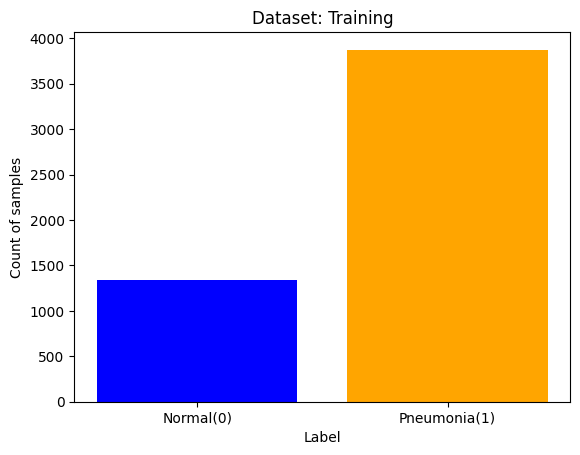

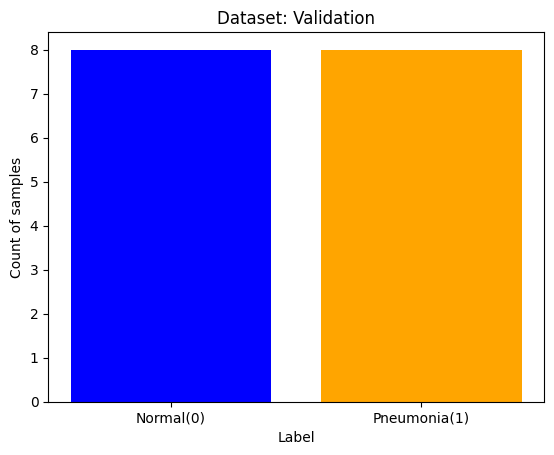

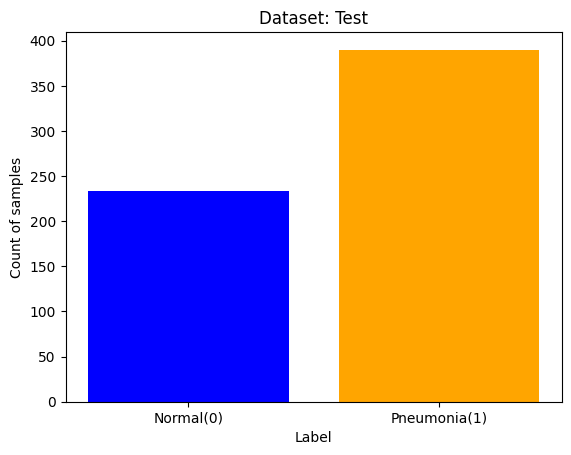

In [23]:
plot_label_counts(training_label_count, "Training")
plot_label_counts(validation_label_count, "Validation")
plot_label_counts(test_label_count, "Test")

Got the label count, however the __dataset is imbalanced but not in the conventional way.__
- For training/test dataset: _The positive classes are in larger number than the negative one_ - opposite of the real-world scenario.
- For Validation, though the number is quite low.

_In the another iteration of the notebook, we will deal with unbalanced dataset._

### Load the dataset

Reusing the `DataLoader` api to load the training and validation dataset in shuffled fashion, with `batch_size = 64`.

In [24]:
training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Modeling <a id="modeling"></a>

### Define the model

Baseline models are useful for knowing what can be done with DL with bare minimum. I am resorting to using simple CNN architecture which is defined below.

__Update: Tried with simple CNN model with 2 CNN layers, 1 FC layer, and ReLU activation, but the model didin't converge. So I have updated the model to better architecture, with additional weighted loss function (computed later in the notebook.)__

In [25]:
import torch.nn as nn

In [26]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256*28*28, 256),
            nn.LeakyReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 1),
            nn.LeakyReLU()
        )
        self.maxpool = nn.MaxPool2d(2,2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.maxpool(self.conv_block_1(x))
        x = self.maxpool(self.conv_block_2(x))
        x = self.maxpool(self.conv_block_3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [27]:
# instantiate the model
model = BasicCNN().to(DEVICE)

Let's print the model to look at it's layers. Pytorch doesn't inherently has model visualization support as Tensorflow, but the layer definition looks fine.

In [28]:
model

BasicCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (fc1): Sequential(
    (0): Linear(in_features=200704, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (maxpool): MaxP

### Training the model

Now that the CNN-model has been defined, let's move onto setting a few helper function that will aid in training, validation, and saving metrics and models.

### Modeling helper functions

In [29]:
from tqdm import tqdm

In [30]:
def save_model(model_name, epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                "epoch": epochs,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": criterion,
                },
                MODEL_DIR / model_name)

In [31]:
def save_plots(model_name, train_acc, valid_acc, train_loss, valid_loss, train_recall, valid_recall):
    """
    Function to save the loss and accuracy plots to disk.
    """
    save_dir = PLOT_DIR/model_name
    os.makedirs(save_dir, exist_ok=True)
    
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color="green", linestyle="-", 
        label="train accuracy"
    )
    plt.plot(
        valid_acc, color="blue", linestyle="-", 
        label="validation accuracy"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(save_dir / "accuracy.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color="orange", linestyle="-", 
        label="train loss"
    )
    plt.plot(
        valid_loss, color="red", linestyle="-", 
        label="validation loss"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(save_dir / "loss.png")

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color="purple", linestyle="-", 
        label="train recall"
    )
    plt.plot(
        valid_loss, color="brown", linestyle="-", 
        label="validation recall"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.savefig(save_dir / "recall.png")

### Note on the metric

In medical field missing a true positive (eg: a disease or condition) can have detrimental consequences, so the emphasis should be put on _Recall_.

Using __Weighted BinaryCrossEntropy loss, weighted accuracy and weighted recall scores__ as metrics.

In [32]:
from sklearn.metrics import balanced_accuracy_score, recall_score

### Get the required params for training

### Correction for data imbalance; weighted loss function

In [33]:
# compute the weights 
num_classes = len(training_dataset.classes)
total_samples = training_label_count.sum()

NEG_WEIGHT = total_samples / (num_classes * training_label_count[0])
POS_WEIGHT = total_samples / (num_classes * training_label_count[1])

In [34]:
NEG_WEIGHT, POS_WEIGHT

(1.9448173005219984, 0.6730322580645162)

In [35]:
def train(model, trainloader, optimizer, criterion, device):
    """trains the model on defined params per epoch and computes the loss/accuracy"""
    
    model.train()
    print("Training")

    # define variables for computing metrics
    train_running_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    counter = 0
    
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        # fetch batch images and labels
        images, labels = data
        images = images.float().to(device)
        labels = labels.unsqueeze(1).float().to(device)
        weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).view(-1, 1).to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # calculate the loss
        loss = criterion(outputs, labels)
        loss = (loss * weights).mean()
        train_running_loss += loss.item()
        
        # calculate the accuracy
        preds = outputs.round() # round the sigmoid activation values.
        
        # backpropagation
        loss.backward()
        
        # update the optimizer parameters
        optimizer.step()

        # append the y and y_hat
        all_train_labels.extend(preds.squeeze().detach().to("cpu").numpy())
        all_train_preds.extend(labels.squeeze().detach().to("cpu").numpy())
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    weighted_epoch_acc = balanced_accuracy_score(all_train_labels, all_train_preds)
    weighted_recall_score = recall_score(all_train_labels, all_train_preds, average="weighted")
    return epoch_loss, weighted_epoch_acc, weighted_recall_score

In [36]:
# validation
def validate(model, testloader, criterion, device):
    """validate the model on validation set per epoch and compute metrics"""
    
    model.eval()
    print('Validation')
    
    valid_running_loss = 0.0
    all_val_labels = []
    all_val_preds = []
    counter = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            images, labels = data
            images = images.float().to(device)
            labels = labels.unsqueeze(1).float().to(device)
            weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).view(-1,1).to(device)
            
            # forward pass
            outputs = model(images)
            
            # calculate the loss
            loss = criterion(outputs, labels)
            loss = (loss * weights).mean()
            valid_running_loss += loss.item()
            
            # calculate the accuracy
            preds = outputs.round()
            all_val_labels.extend(labels.squeeze().to("cpu").numpy())
            all_val_preds.extend(preds.squeeze().to("cpu").numpy())
            
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    weighted_epoch_acc = balanced_accuracy_score(all_val_labels, all_val_preds)
    weighted_recall_score = recall_score(all_val_labels, all_val_preds, average="weighted")
    return epoch_loss, weighted_epoch_acc, weighted_recall_score

### Get the required params for training

Let's set the loss_function and optimizer for training the model.
Resoring to `BCELoss` and `SGD` optimizer.

In [37]:
criterion = nn.BCELoss(reduction="none")
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05, momentum=0.9)

### Training loop

Finally the main event, training of the model with the X-ray dataset.

In [1]:
# training loop

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
train_recall, valid_recall = [], []

# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc, train_epoch_recall = train(model, training_loader, 
                                                  optimizer, criterion, DEVICE)
    valid_epoch_loss, valid_epoch_acc, valid_epoch_recall = validate(model, validation_loader,  
                                                     criterion, DEVICE)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    train_recall.append(train_epoch_recall)
    valid_recall.append(valid_epoch_recall)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training recall: {train_epoch_recall:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, validation recall: {valid_epoch_recall:.3f}")
    print('-'*50)

NameError: name 'EPOCHS' is not defined

TRAINING COMPLETE


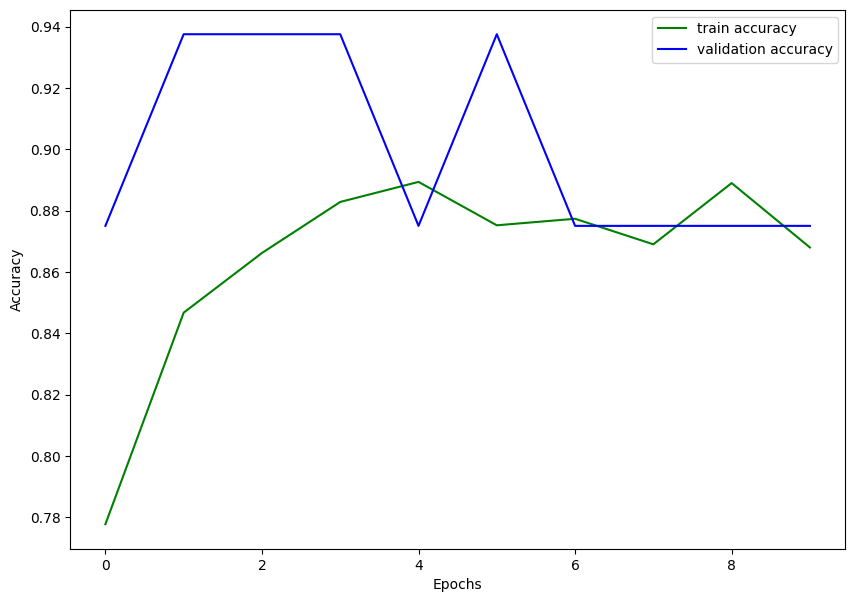

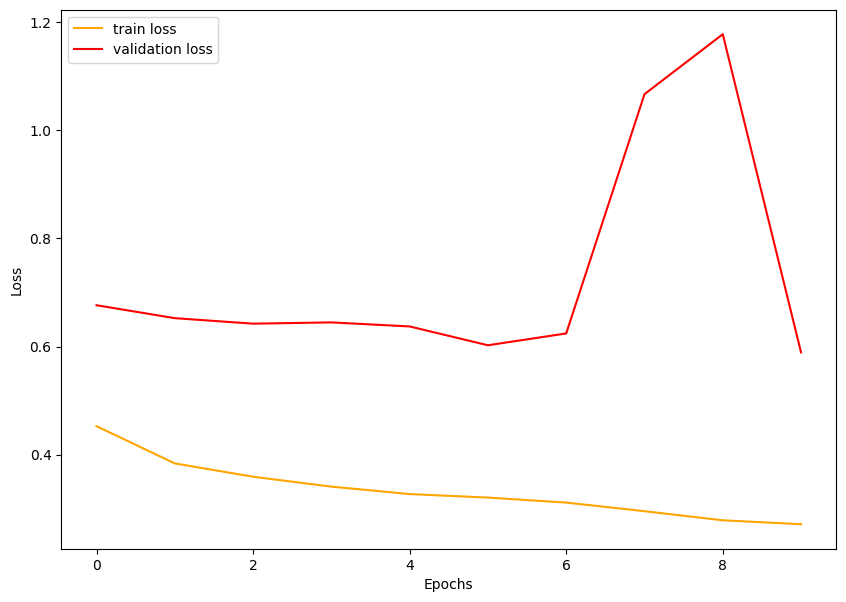

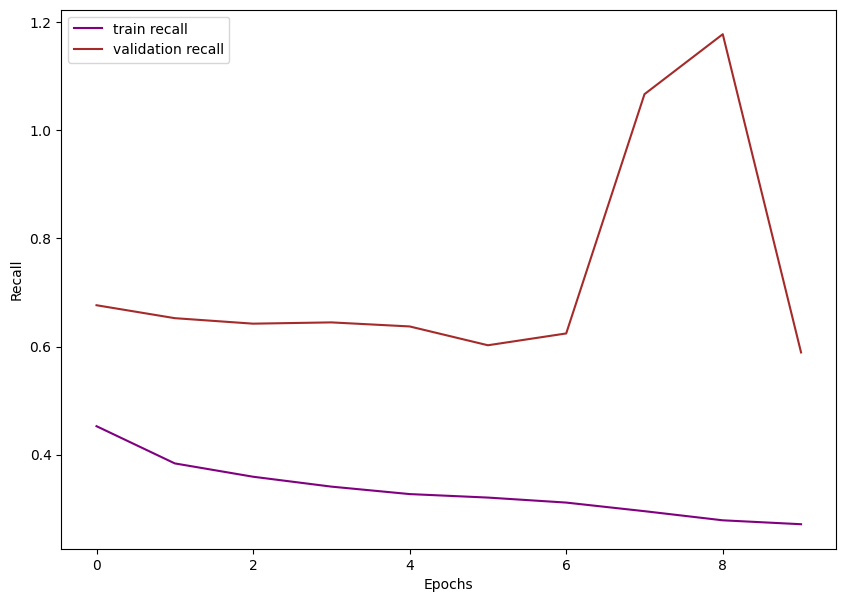

In [40]:
# save the trained model weights
save_model("baseline_cnn.pth", EPOCHS, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots("baseline_cnn", train_acc, valid_acc, train_loss, valid_loss, train_recall, valid_recall)
print('TRAINING COMPLETE')

## Evaluation <a id="evaluation"></a>

In [3]:
import torch

In [40]:
model.load_state_dict(torch.load("../models/baseline_cnn.pth")["model_state_dict"])
model.eval()

BasicCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (fc1): Sequential(
    (0): Linear(in_features=200704, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (maxpool): MaxP

Using `classification_report` from sklearn for evaluation of the model's performance.

In [41]:
from sklearn.metrics import classification_report

### load the test dataset

In [42]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### Compute the testing loop and metrics computation

In [43]:
total_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        weights = torch.where(labels==1, POS_WEIGHT, NEG_WEIGHT).view(-1,1).to(DEVICE)
        
        outputs = model(inputs.to(DEVICE))
        labels = labels.unsqueeze(1).float().to(DEVICE)
        loss = criterion(outputs, labels)
        loss = (weights * loss).mean()
        
        total_loss += loss.item()

        preds = outputs.round()

        all_labels.extend(labels.squeeze().to('cpu').numpy())
        all_preds.extend(preds.squeeze().to('cpu').numpy())


In [44]:
average_loss = total_loss / len(test_loader.dataset)

print(f'Average Test Loss: {average_loss:.4f}')

Average Test Loss: 0.1376


In [45]:
print(classification_report(all_labels, all_preds, target_names = test_loader.dataset.classes))

              precision    recall  f1-score   support

      NORMAL       0.84      0.76      0.80       234
   PNEUMONIA       0.86      0.92      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.86      0.86      0.85       624



In [46]:
balanced_accuracy_score(all_labels, all_preds)

0.8358974358974358

- Balanced accuracy score is 83%
- Recall is low for the -ve cases -> The model is failing to identify -ve cases properly.
While for +ve cases, precision is lower -> falsely identifying pneumonia as normal.

## Further Improvements

In the next iteration, I will be using the following techniques to:

1. transfer learning
2. oversampling methods

